In [1]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Load human and mouse processed data

In [57]:
human_adata = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/human_pancreas_one_sample_preprocessed_adata.h5ad")
mouse_adata = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/mouse_pancreas_all_samples_preprocessed_adata.h5ad")

In [58]:
human_adata

AnnData object with n_obs × n_vars = 1937 × 16359
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [59]:
mouse_adata

AnnData object with n_obs × n_vars = 1886 × 14466
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_types_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [60]:
# inspect 20 bottom rows of mouse anndata object
mouse_adata.var.tail(20)

,gene_name,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
ZSCAN21,ZSCAN21,90,False,90,0.063627,95.227996,120.0
ZSCAN22,ZSCAN22,87,False,87,0.066278,95.387063,125.0
ZSCAN29,ZSCAN29,58,False,58,0.038706,96.924708,73.0
ZSWIM1,ZSWIM1,88,False,88,0.055143,95.334040,104.0
ZSWIM3,ZSWIM3,25,False,25,0.014316,98.674443,27.0
ZSWIM4,ZSWIM4,211,False,211,0.151113,88.812301,285.0
ZSWIM5,ZSWIM5,56,False,56,0.037646,97.030753,71.0
ZSWIM7,ZSWIM7,62,False,62,0.036585,96.712619,69.0
ZSWIM8,ZSWIM8,605,False,605,0.470308,67.921527,887.0
ZUFSP,ZUFSP,45,False,45,0.025981,97.613998,49.0


# Load homology information

In [8]:
# load in homology dataset
homology_df = pd.read_csv("/home/sr2464/Desktop/CellLM/datasets/homolog_df_with_similarity_scores_and_avg_expr_goc_wga_score.csv", index_col=0)
homology_df.shape

(22232, 13)

In [9]:
# filter homology dataset
homology_df = homology_df[["human_homolog_ENS_ID", "mouse_homolog_ENS_ID", "Sequence_Similarity_Score", "goc_score", "wga_score"]]
homology_df.shape

(22232, 5)

In [10]:
# inspect first 5 rows of filtered data
# table represents homologous gene pairs between humans and mice, along with metrics that describe their sequence similarity
homology_df.head()

,human_homolog_ENS_ID,mouse_homolog_ENS_ID,Sequence_Similarity_Score,goc_score,wga_score
0,ENSG00000198888,ENSMUSG00000064341,77.0440,50.0,100.0
1,ENSG00000198763,ENSMUSG00000064345,57.3913,75.0,100.0
2,ENSG00000198804,ENSMUSG00000064351,90.6615,100.0,100.0
3,ENSG00000198712,ENSMUSG00000064354,71.3656,100.0,100.0
4,ENSG00000228253,ENSMUSG00000064356,46.2687,100.0,100.0


Load mapping of ensembl IDs to gene names for both human and mouse. 

Ensembl IDs are crucial for genomic research, providing a reliable and standardized way to refer to genes and other genomic elements. 

In [11]:
# read in human gene mappings from csv
human_map_df = pd.read_csv(
    "/home/sr2464/Desktop/C2S_Cross_Species/human_map.csv", 
    index_col=0, 
    names=['gene_name', 'ensembl_id'],
    skiprows=1,  # ignore first row containing switched col names
)
print(human_map_df.shape)
human_map_df.head(30)

(36601, 2)


,gene_name,ensembl_id
0,MIR1302-2HG,ENSG00000243485
1,FAM138A,ENSG00000237613
2,OR4F5,ENSG00000186092
3,AL627309.1,ENSG00000238009
4,AL627309.3,ENSG00000239945
5,AL627309.2,ENSG00000239906
6,AL627309.5,ENSG00000241860
7,AL627309.4,ENSG00000241599
8,AP006222.2,ENSG00000286448
9,AL732372.1,ENSG00000236601


In [12]:
# construct dictionary to map gene names (with and without version numbers) to Ensemble ID
# useful for creating a lookup table that can be used to quickly find the Ensembl ID for a given gene name, accommodating both exact names and those without version numbers
human_gene_to_ens_id_map = {}
for idx in tqdm(range(human_map_df.shape[0])):
    gene_name = human_map_df.iloc[idx]["gene_name"]
    ensembl_id = human_map_df.iloc[idx]["ensembl_id"]

    # Put gene name with version number into mapping
    # This also guarantees gene name with no version number overrides anything set later in loop
    human_gene_to_ens_id_map[gene_name] = ensembl_id

    # Get gene name without version number
    gene_name_wout_version_num = gene_name if "." not in gene_name else gene_name.split(".")[0]
    if gene_name_wout_version_num not in human_gene_to_ens_id_map:
        human_gene_to_ens_id_map[gene_name_wout_version_num] = ensembl_id

100%|██████████| 36601/36601 [00:02<00:00, 16542.81it/s]


In [13]:
print(human_gene_to_ens_id_map["AL627309"])
print(human_gene_to_ens_id_map["AL627309.1"])
print(human_gene_to_ens_id_map["AL627309.2"])
print(human_gene_to_ens_id_map["AL627309.3"])
print(human_gene_to_ens_id_map["AL627309.5"])
print()
print(human_gene_to_ens_id_map["AL645608"])
print(human_gene_to_ens_id_map["AL645608.6"])
print(human_gene_to_ens_id_map["AL645608.1"])

ENSG00000238009
ENSG00000238009
ENSG00000239906
ENSG00000239945
ENSG00000241860

ENSG00000272438
ENSG00000272438
ENSG00000224969


Repeat for mouse

In [14]:
# read in mouse gene mappings from csv
mouse_map_df = pd.read_csv(
    "/home/sr2464/Desktop/C2S_Cross_Species/mouse_map.csv", 
    index_col=0, 
    names=['gene_name', 'ensembl_id'],
    skiprows=1,  # ignore first row containing switched col names
)
print(mouse_map_df.shape)
mouse_map_df.head(20)

(32285, 2)


,gene_name,ensembl_id
0,Xkr4,ENSMUSG00000051951
1,Gm1992,ENSMUSG00000089699
2,Gm19938,ENSMUSG00000102331
3,Gm37381,ENSMUSG00000102343
4,Rp1,ENSMUSG00000025900
5,Sox17,ENSMUSG00000025902
6,Gm37587,ENSMUSG00000104238
7,Gm37323,ENSMUSG00000104328
8,Mrpl15,ENSMUSG00000033845
9,Lypla1,ENSMUSG00000025903


In [15]:
# construct dictionary to map gene names (with and without version numbers) to Ensemble ID for mice
# useful for creating a lookup table that can be used to quickly find the Ensembl ID for a given gene name, accommodating both exact names and those without version numbers
mouse_gene_to_ens_id_map = {}
for idx in tqdm(range(mouse_map_df.shape[0])):
    gene_name = mouse_map_df.iloc[idx]["gene_name"].upper()
    ensembl_id = mouse_map_df.iloc[idx]["ensembl_id"]

    # Put gene name with version number into mapping
    # This also guarantees gene name with no version number overrides anything set later in loop
    mouse_gene_to_ens_id_map[gene_name] = ensembl_id

    # Get gene name without version number
    gene_name_wout_version_num = gene_name if "." not in gene_name else gene_name.split(".")[0]
    if gene_name_wout_version_num not in mouse_gene_to_ens_id_map:
        mouse_gene_to_ens_id_map[gene_name_wout_version_num] = ensembl_id

100%|██████████| 32285/32285 [00:02<00:00, 14830.48it/s]


In [16]:
print(mouse_gene_to_ens_id_map["Xkr4".upper()])
print(mouse_gene_to_ens_id_map["Gm1992".upper()])
print(mouse_gene_to_ens_id_map["Gm19938".upper()])
print(mouse_gene_to_ens_id_map["St18".upper()])

ENSMUSG00000051951
ENSMUSG00000089699
ENSMUSG00000102331
ENSMUSG00000033740


In [17]:
print(mouse_gene_to_ens_id_map["Gnai3".upper()])
print(mouse_gene_to_ens_id_map["Pbsn".upper()])
print(mouse_gene_to_ens_id_map["Cdc45".upper()])
print(mouse_gene_to_ens_id_map["H19".upper()])
print(mouse_gene_to_ens_id_map["Scml2".upper()])  # Matches what we had in below mapping df! Great sign

ENSMUSG00000000001
ENSMUSG00000000003
ENSMUSG00000000028
ENSMUSG00000000031
ENSMUSG00000000037


In [18]:
# create list of Ensembl IDs for the mouse genes based on the lookup dictionary, 
# ensuring that missing values are recorded as "Nan" to indicate genes for which Ensembl IDs are not available
mouse_ens_id_list = []
for idx in range(mouse_adata.var.shape[0]):
    gene_name = mouse_adata.var.iloc[idx]["gene_name"].upper()
    gene_ens_id = mouse_gene_to_ens_id_map.get(gene_name, "NaN")
    mouse_ens_id_list.append(gene_ens_id)

In [19]:
mouse_ens_id_list[:10]

['ENSMUSG00000057561',
 'ENSMUSG00000036103',
 'ENSMUSG00000024525',
 'ENSMUSG00000056515',
 'ENSMUSG00000012114',
 'ENSMUSG00000014932',
 'ENSMUSG00000024277',
 'ENSMUSG00000042514',
 'ENSMUSG00000079509',
 'ENSMUSG00000020435']

In [20]:
# count number of genes for which Ensemble IDs are not available
sum([1 if name == "NaN" else 0 for name in mouse_ens_id_list])

0

In [21]:
# add column to mouse_adata to indicate associated ensemble_id for gene
mouse_adata.var["ensembl_id"] = mouse_ens_id_list
mouse_adata.var.head()

,gene_name,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ensembl_id
EIF1A,EIF1A,468,False,468,0.363733,75.185578,686.0,ENSMUSG00000057561
COLEC12,COLEC12,5,False,5,0.002651,99.734889,5.0,ENSMUSG00000036103
IMPA2,IMPA2,30,False,30,0.021739,98.409332,41.0,ENSMUSG00000024525
RAB31,RAB31,110,False,110,0.085366,94.167550,161.0,ENSMUSG00000056515
MED15,MED15,247,False,247,0.167020,86.903499,315.0,ENSMUSG00000012114


In [22]:
# inspect tail of mouse_adata
mouse_adata.var.tail()

,gene_name,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ensembl_id
NTRK1,NTRK1,15,False,15,0.007953,99.204666,15.0,ENSMUSG00000028072
ACOT7,ACOT7,89,False,89,0.068399,95.281018,129.0,ENSMUSG00000028937
ESPN,ESPN,9,False,9,0.005832,99.522800,11.0,ENSMUSG00000028943
CACNA1E,CACNA1E,12,False,12,0.006893,99.363733,13.0,ENSMUSG00000004110
SPATA1,SPATA1,34,False,34,0.019088,98.197243,36.0,ENSMUSG00000028188


Repeat for human adata

Add human ens ids to human adata

In [23]:
# create list of Ensembl IDs for the human genes based on the lookup dictionary, 
# ensuring that missing values are recorded as "Nan" to indicate genes for which Ensembl IDs are not available
human_ens_id_list = []
for idx in tqdm(range(human_adata.var.shape[0])):
    gene_name = human_adata.var.iloc[idx]["gene_name"].upper()
    if "." in gene_name:
        gene_name = gene_name.split(".")[0]
    gene_ens_id = human_gene_to_ens_id_map.get(gene_name, "NaN")
    human_ens_id_list.append(gene_ens_id)

100%|██████████| 12113/12113 [00:01<00:00, 9409.57it/s]


In [24]:
# count number of genes for which Ensemble IDs are not available
sum([1 if name == "NaN" else 0 for name in human_ens_id_list])

0

In [25]:
# add column to mouse_adata to indicate associated ensemble_id for gene
human_adata.var["ensembl_id"] = human_ens_id_list
human_adata.var.head()

,gene_name,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ensembl_id
EIF1AY,EIF1AY,1464,False,1464,0.217062,82.915159,1860.0,ENSG00000198692
COLEC12,COLEC12,9,False,9,0.001400,99.894970,12.0,ENSG00000158270
IMPA2,IMPA2,2425,False,2425,0.627728,71.700315,5379.0,ENSG00000141401
RAB31,RAB31,1780,False,1780,0.386976,79.227448,3316.0,ENSG00000168461
MED15,MED15,1781,False,1781,0.266309,79.215778,2282.0,ENSG00000099917


# Restrict Human and Mouse adata objects to homologous genes

In [26]:
# this function:
#   (1) extracts homologous gene ids for humans and mice
#   (2) filters objects to retain only the homologous genes
#   (3) ensures the homologous genes are consistently ordered in both human and mouse ann data objects 
#   (4) returns the filtered and consistently ordered anndata object for further analysis

def restrict_to_homologous_genes(human_adata, mouse_adata, homolog_df):
    # Extract homologous Ensembl IDs
    human_homologs = homolog_df['human_homolog_ENS_ID'].values
    mouse_homologs = homolog_df['mouse_homolog_ENS_ID'].values

    # Create masks for human and mouse AnnData objects based on homologous Ensembl IDs
    human_mask = human_adata.var['ensembl_id'].isin(human_homologs)
    mouse_mask = mouse_adata.var['ensembl_id'].isin(mouse_homologs)

    # Restrict both AnnData objects to homologous genes
    human_restricted = human_adata[:, human_mask].copy()
    mouse_restricted = mouse_adata[:, mouse_mask].copy()

    # Initialize empty lists for indices where both human and mouse homologous genes exist
    human_order = []
    mouse_order = []

    # Loop through the homologous pairs to ensure both human and mouse have the homologous gene
    for human_id, mouse_id in zip(human_homologs, mouse_homologs):
        if human_id in human_restricted.var['ensembl_id'].values and mouse_id in mouse_restricted.var['ensembl_id'].values:
            # Get the index of the homologous gene in both human and mouse
            human_idx = human_restricted.var['ensembl_id'].tolist().index(human_id)
            mouse_idx = mouse_restricted.var['ensembl_id'].tolist().index(mouse_id)
            
            # Append the index if both human and mouse have the gene
            human_order.append(human_idx)
            mouse_order.append(mouse_idx)

    # Reorder AnnData objects to match the homologous gene ordering
    human_restricted = human_restricted[:, human_order].copy()
    mouse_restricted = mouse_restricted[:, mouse_order].copy()

    return human_restricted, mouse_restricted

In [27]:
# call function to store filtered and ordered AnnData objects for both humans and mice
human_restricted, mouse_restricted = restrict_to_homologous_genes(human_adata, mouse_adata, homology_df)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
# inspect human_restricted anndata object
human_restricted

AnnData object with n_obs × n_vars = 8569 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [29]:
human_restricted.var.head(10)

,gene_name,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ensembl_id
EIF1AY,EIF1AY,1464,False,1464,0.217062,82.915159,1860.0,ENSG00000198692
COLEC12,COLEC12,9,False,9,0.001400,99.894970,12.0,ENSG00000158270
IMPA2,IMPA2,2425,False,2425,0.627728,71.700315,5379.0,ENSG00000141401
RAB31,RAB31,1780,False,1780,0.386976,79.227448,3316.0,ENSG00000168461
MED15,MED15,1781,False,1781,0.266309,79.215778,2282.0,ENSG00000099917
YES1,YES1,1510,False,1510,0.243902,82.378341,2090.0,ENSG00000176105
MAPRE2,MAPRE2,2320,False,2320,0.405998,72.925662,3479.0,ENSG00000166974
KLHL14,KLHL14,6,False,6,0.000700,99.929980,6.0,ENSG00000197705
ZFY,ZFY,194,False,194,0.027191,97.736025,233.0,ENSG00000067646
OSBP2,OSBP2,129,False,129,0.015988,98.494573,137.0,ENSG00000184792


In [30]:
# inspect mouse restricted anndata object
mouse_restricted

AnnData object with n_obs × n_vars = 1886 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ensembl_id'

In [31]:
mouse_restricted.var.head(10)

,gene_name,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,ensembl_id
EIF1A,EIF1A,468,False,468,0.363733,75.185578,686.0,ENSMUSG00000057561
COLEC12,COLEC12,5,False,5,0.002651,99.734889,5.0,ENSMUSG00000036103
IMPA2,IMPA2,30,False,30,0.021739,98.409332,41.0,ENSMUSG00000024525
RAB31,RAB31,110,False,110,0.085366,94.167550,161.0,ENSMUSG00000056515
MED15,MED15,247,False,247,0.167020,86.903499,315.0,ENSMUSG00000012114
YES1,YES1,130,False,130,0.086957,93.107105,164.0,ENSMUSG00000014932
MAPRE2,MAPRE2,626,False,626,0.693001,66.808059,1307.0,ENSMUSG00000024277
KLHL14,KLHL14,4,False,4,0.002651,99.787911,5.0,ENSMUSG00000042514
ZFX,ZFX,221,False,221,0.172853,88.282078,326.0,ENSMUSG00000079509
OSBP2,OSBP2,15,False,15,0.008484,99.204666,16.0,ENSMUSG00000020435


Quickly remake marker gene heatmaps to ensure that marker genes were not lost in homolog intersection

In [32]:
# ensure there are no duplicate gene names within each anndata object
# prevents potential downstream analysis/data manipulation issues that require unique var names
# maintain clear/unambiguous identification of each gene in the datasets
human_restricted.var_names_make_unique()
mouse_restricted.var_names_make_unique()

In [33]:
# define list of marker genes for human and mouse cells
# convert all mouse marker gene names to upercase to ensure consistency in naming conventions
human_marker_genes = ['GCG', 'INS', 'PPY', 'SST', 'GHRL', 'PRSS1', 'KRT19', 'SPARC', 'VWF', 'RGS5', 'PDGFRA', 'SOX10']  # , 'SDS', 'TPSAB1', 'TRAC'
mouse_marker_genes = ['Gcg', 'Ins1', 'Ins2', 'Ppy', 'Sst', 'Krt19', 'Sparc', 'Pecam1', 'Rgs5', 'Pdgfra', 'Sox10', 'Ptprc', 'Flt3', 'Iglc3']  # , 'Lyz2', 'Trac'
mouse_marker_genes = [gene_name.upper() for gene_name in mouse_marker_genes]

In [34]:
# Define the directory and file path
save_path = "/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_pancreas_one_sample_marker_gene_heatmap.png"
save_dir = os.path.dirname(save_path)

# Create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


         Falling back to preprocessing with `sc.pp.pca` and default params.


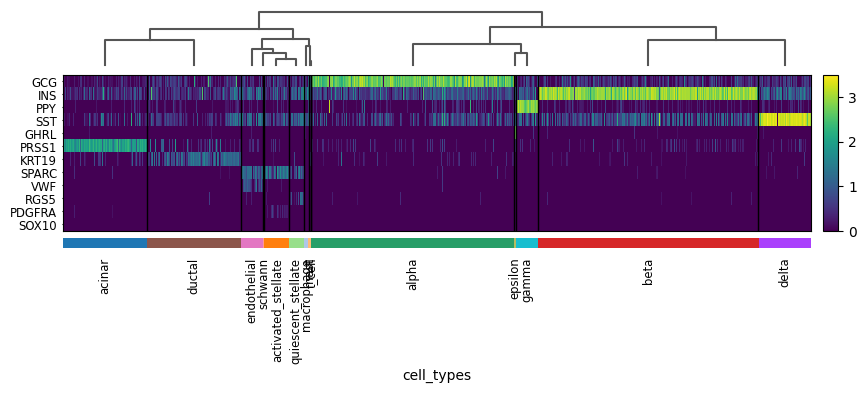

In [35]:
# generate heatmap to visualize expression levels of set of human marker genes across cell types in the filtered homologous human gene data
# heatmap provides insights into expression patterns of key marker genes across various cell types, helping to identify and compare the cellular composition and functional states within the human pancreas tissue sample
sc.pl.heatmap(
    human_restricted, 
    human_marker_genes, 
    groupby='cell_types', 
    swap_axes=True,
    dendrogram=True,
    show=False
)
plt.savefig("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_pancreas_one_sample_marker_gene_heatmap.png",
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

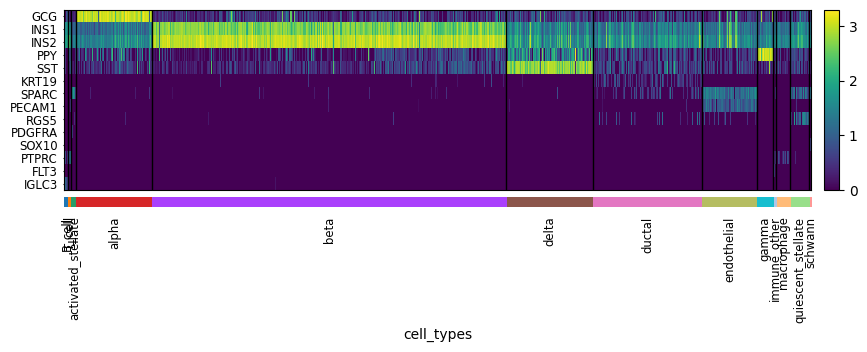

In [36]:
# generate heatmap to visualize expression levels of set of human marker genes across cell types in the filtered homologous human gene data
# heatmap provides insights into expression patterns of key marker genes across various cell types, helping to identify and compare the cellular composition and functional states within the mouse pancreas tissue sample.
sc.pl.heatmap(
    mouse_restricted, 
    mouse_marker_genes, 
    groupby='cell_types', 
    swap_axes=True,
    # dendrogram=True,
    show=False
)
plt.savefig("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/mouse_pancreas_marker_gene_heatmap.png",
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

In [37]:
# remove unnecessary data in human + mouse restricted anndata objects
#   .uns <- stores unstructured annotations
#   .obsm <- stores multi-dimensional annotations for observations (cells)
#   .varm <- stores multi-dimensional annotations for variables (genes)
#   .obsp <- stores pairwise matrices between observations (cells) 

del human_restricted.uns
del human_restricted.obsm
del human_restricted.varm
del human_restricted.obsp

del mouse_restricted.uns
del mouse_restricted.obsm
del mouse_restricted.varm
del mouse_restricted.obsp

In [38]:
human_restricted.write_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_pancreas_one_sample_preprocessed_homolog_intersected_adata.h5ad")
mouse_restricted.write_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/mouse_pancreas_preprocessed_homolog_intersected_adata.h5ad")

In [39]:
human_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_pancreas_one_sample_preprocessed_homolog_intersected_adata.h5ad")
mouse_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/mouse_pancreas_preprocessed_homolog_intersected_adata.h5ad")

# Create cross-species AnnData object

In [40]:
# summarize information about homologous gene pairs between human and mouse cells
# for each pair, include an index, the human+mouse gene names, the human+mouse Ensembl gene IDs
homolog_pair_df_index = [f"homolog_pair_{idx}" for idx in range(human_restricted.var.shape[0])]
var_df = pd.DataFrame({
    "homolog_pair_idx": homolog_pair_df_index,
    "human_gene_name": human_restricted.var["gene_name"].tolist(),
    "mouse_gene_name": mouse_restricted.var["gene_name"].tolist(),
    "human_gene_ensembl_id": human_restricted.var["ensembl_id"].tolist(),
    "mouse_gene_ensembl_id": mouse_restricted.var["ensembl_id"].tolist(),
}, index=homolog_pair_df_index)
print(var_df.shape)
var_df.head(10)

(12113, 5)


,homolog_pair_idx,human_gene_name,mouse_gene_name,human_gene_ensembl_id,mouse_gene_ensembl_id
homolog_pair_0,homolog_pair_0,EIF1AY,EIF1A,ENSG00000198692,ENSMUSG00000057561
homolog_pair_1,homolog_pair_1,COLEC12,COLEC12,ENSG00000158270,ENSMUSG00000036103
homolog_pair_2,homolog_pair_2,IMPA2,IMPA2,ENSG00000141401,ENSMUSG00000024525
homolog_pair_3,homolog_pair_3,RAB31,RAB31,ENSG00000168461,ENSMUSG00000056515
homolog_pair_4,homolog_pair_4,MED15,MED15,ENSG00000099917,ENSMUSG00000012114
homolog_pair_5,homolog_pair_5,YES1,YES1,ENSG00000176105,ENSMUSG00000014932
homolog_pair_6,homolog_pair_6,MAPRE2,MAPRE2,ENSG00000166974,ENSMUSG00000024277
homolog_pair_7,homolog_pair_7,KLHL14,KLHL14,ENSG00000197705,ENSMUSG00000042514
homolog_pair_8,homolog_pair_8,ZFY,ZFX,ENSG00000067646,ENSMUSG00000079509
homolog_pair_9,homolog_pair_9,OSBP2,OSBP2,ENSG00000184792,ENSMUSG00000020435


In [41]:
# remove metadata associated with the genes (variables = genes)
del human_restricted.var
del mouse_restricted.var

In [42]:
# ensure that both human and mouse datasets have consistent and matched gene metadata 
human_restricted.var = var_df
mouse_restricted.var = var_df
human_restricted.var_names = var_df.index.tolist()
mouse_restricted.var_names = var_df.index.tolist()

In [43]:
# combine these datasets for integrated analysis
human_mouse_adata = anndata.concat([human_restricted, mouse_restricted], axis=0)
human_mouse_adata.var = var_df
human_mouse_adata

AnnData object with n_obs × n_vars = 10455 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'homolog_pair_idx', 'human_gene_name', 'mouse_gene_name', 'human_gene_ensembl_id', 'mouse_gene_ensembl_id'

In [44]:
human_mouse_adata.var.head(10)

,homolog_pair_idx,human_gene_name,mouse_gene_name,human_gene_ensembl_id,mouse_gene_ensembl_id
homolog_pair_0,homolog_pair_0,EIF1AY,EIF1A,ENSG00000198692,ENSMUSG00000057561
homolog_pair_1,homolog_pair_1,COLEC12,COLEC12,ENSG00000158270,ENSMUSG00000036103
homolog_pair_2,homolog_pair_2,IMPA2,IMPA2,ENSG00000141401,ENSMUSG00000024525
homolog_pair_3,homolog_pair_3,RAB31,RAB31,ENSG00000168461,ENSMUSG00000056515
homolog_pair_4,homolog_pair_4,MED15,MED15,ENSG00000099917,ENSMUSG00000012114
homolog_pair_5,homolog_pair_5,YES1,YES1,ENSG00000176105,ENSMUSG00000014932
homolog_pair_6,homolog_pair_6,MAPRE2,MAPRE2,ENSG00000166974,ENSMUSG00000024277
homolog_pair_7,homolog_pair_7,KLHL14,KLHL14,ENSG00000197705,ENSMUSG00000042514
homolog_pair_8,homolog_pair_8,ZFY,ZFX,ENSG00000067646,ENSMUSG00000079509
homolog_pair_9,homolog_pair_9,OSBP2,OSBP2,ENSG00000184792,ENSMUSG00000020435


# Joint UMAP

In [45]:
human_mouse_adata

AnnData object with n_obs × n_vars = 10455 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'homolog_pair_idx', 'human_gene_name', 'mouse_gene_name', 'human_gene_ensembl_id', 'mouse_gene_ensembl_id'

In [46]:
# Run Principal Component Analysis (PCA) on human_mouse data: (Data is linearly transformed onto a new coordinate system such that the directions capturing the largest variation in the data can be easily identified)
sc.tl.pca(human_mouse_adata)

In [47]:
# Compute nearest neighbors distance matrix and a neighborhood graph of observations for human_mouse data
# Per documentation, returns ann_data object with a compressed sparse row matrix containing the distance matrix of the nearest neighbors search
# In the ann_data object, each cell (row) contains the distance to their 14 nearest neighbors (default # neighbors = 14)
sc.pp.neighbors(human_mouse_adata)

In [48]:
# compute the UMAP embedding for the human_mouse object, reducing the dimensionality and enabling visualization of the high-dim gene expression data in a low-dim space for plotting purposes
sc.tl.umap(human_mouse_adata)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


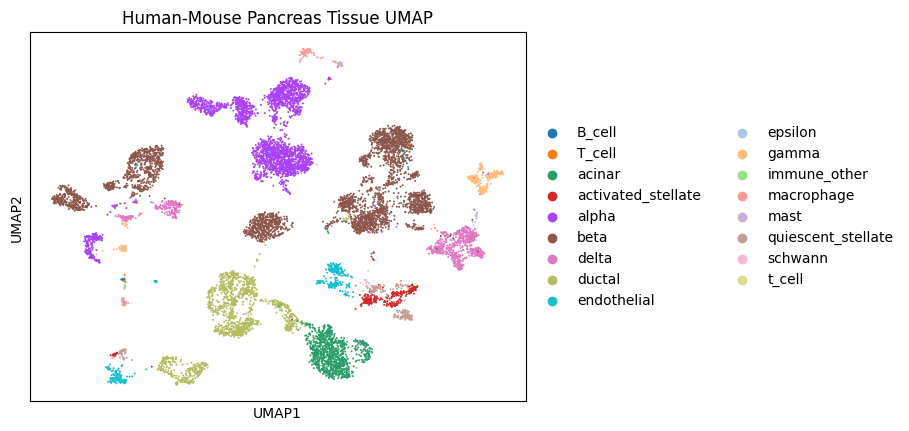

In [49]:
# generate 2D UMAP plot of the human_mouse AnnData object, coloring points by cell types and save plot  
sc.pl.umap(
    human_mouse_adata,
    color="cell_types",
    # Setting a smaller point size to get prevent overlap
    size=8,
    title="Human-Mouse Pancreas Tissue UMAP",
    show=False
)
plt.savefig("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap.png",
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

In [50]:
# inspect human_mouse data
human_mouse_adata.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,human1_lib1.final_cell_0001,acinar,GSM2230757_human1_umifm_counts,3526,3526,22412.0,0.0,0.0
human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,human1_lib1.final_cell_0002,acinar,GSM2230757_human1_umifm_counts,4201,4201,27953.0,0.0,0.0
human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,human1_lib1.final_cell_0003,acinar,GSM2230757_human1_umifm_counts,2119,2118,16894.0,0.0,0.0
human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,human1_lib1.final_cell_0004,acinar,GSM2230757_human1_umifm_counts,2956,2956,19300.0,0.0,0.0
human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,human1_lib1.final_cell_0005,acinar,GSM2230757_human1_umifm_counts,2715,2715,15067.0,0.0,0.0


In [51]:
# iterate thru the rows of the obs attribute in teh human_mouse_adata object
# construct composite labels that combine species and cell types
# collect these labels in two separate lists
species_cell_type_label = [] # store composite labels of the form "species_celltype"
species_label_list = [] # store labels for each cell
for idx in range(human_mouse_adata.obs.shape[0]):
    obs_row = human_mouse_adata.obs.iloc[idx] # retrieve metadata for current cell 
    species_label = str(human_mouse_adata.obs.index.tolist()[idx]) 
    species_label = species_label.split("_")[0][:-1]
    cell_type_label = obs_row["cell_types"]
    species_cell_type_label.append(species_label + "_" + cell_type_label) # append composite label to list
    species_label_list.append(species_label) # append species label to list

In [52]:
print(len(species_cell_type_label))
print(len(species_label_list))

10455
10455


In [53]:
human_mouse_adata.obs["species_cell_type_label"] = species_cell_type_label
human_mouse_adata.obs["species_label"] = species_label_list

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


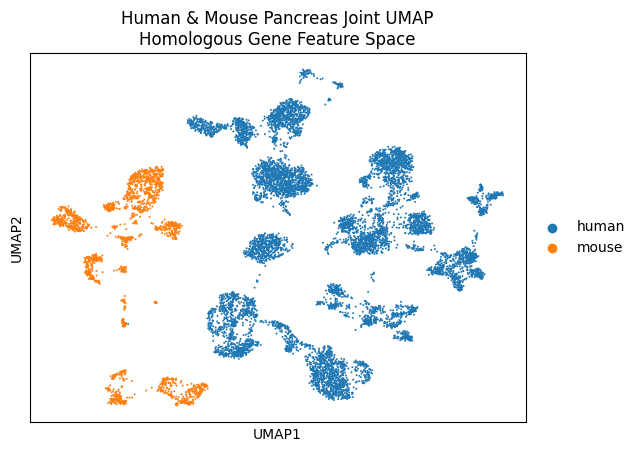

In [54]:
# generate 2D UMAP plot of the human_mouse AnnData object, color points based on species 

sc.pl.umap(
    human_mouse_adata,
    color="species_label",
    # Setting a smaller point size to get prevent overlap
    size=8,
    title="Human & Mouse Pancreas Joint UMAP\nHomologous Gene Feature Space",
    show=False
)
plt.savefig("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_color_species.png",
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


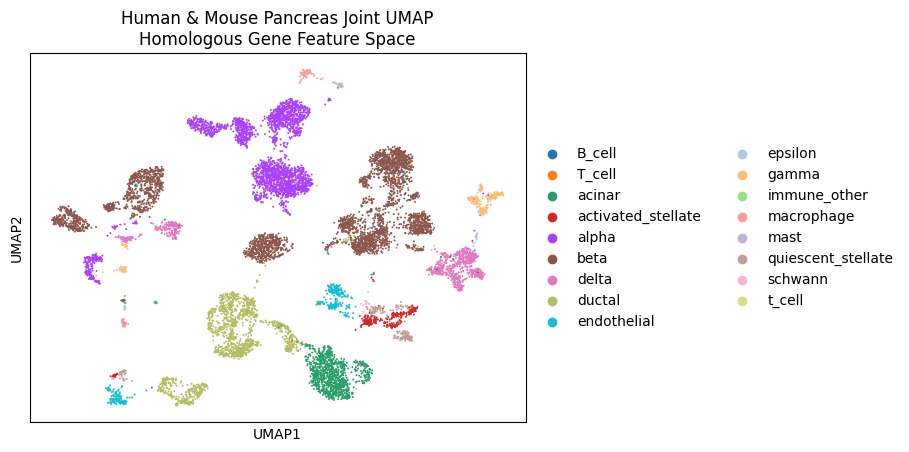

In [55]:
# generate 2D UMAP plot of the human_mouse AnnData object, making points smaller so as to reduce overlap, and save plot  
sc.pl.umap(
    human_mouse_adata,
    color="cell_types",
    # Setting a smaller point size to get prevent overlap
    size=8,
    title="Human & Mouse Pancreas Joint UMAP\nHomologous Gene Feature Space",
    show=False
)
plt.savefig("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_color_cell_type.png",
            facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()

In [56]:
human_mouse_adata.write_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_preprocessed_joint_adata.h5ad")